In [1]:
import pandas as pd
import numpy as np

# GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

# anomaly detection using Bayesian Networks
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore

from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

import matplotlib.pylab as plt

# cluster based anomaly detection (k-means) 
from sklearn.cluster import KMeans

# cluster based anomaly detection (GMM) 
from sklearn.mixture import GaussianMixture

from sklearn.neighbors import LocalOutlierFactor

## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [2]:
df = pd.read_csv("PittsburghTrafficCounts.csv")
df.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [3]:
# your code here
df['log_counts'] = np.log(df['AvgDailyTrafficCount'])
print(df.shape)
df.head()

(1115, 4)


,Longitude,Latitude,AvgDailyTrafficCount,log_counts
0,-80.278366,40.468606,84.0,4.430817
1,-80.162117,40.384598,95.0,4.553877
2,-80.221205,40.366778,97.0,4.574711
3,-80.142455,40.622084,111.0,4.709530
4,-80.131975,40.544915,125.0,4.828314


In [4]:
df['centered_log_counts'] = df['log_counts'] - df['log_counts'].mean()
print(df.shape)
df.head()

(1115, 5)


,Longitude,Latitude,AvgDailyTrafficCount,log_counts,centered_log_counts
0,-80.278366,40.468606,84.0,4.430817,-3.977526
1,-80.162117,40.384598,95.0,4.553877,-3.854466
2,-80.221205,40.366778,97.0,4.574711,-3.833632
3,-80.142455,40.622084,111.0,4.709530,-3.698812
4,-80.131975,40.544915,125.0,4.828314,-3.580029


In [5]:
x_obs = df[['Longitude', 'Latitude']]
y_obs = df[['centered_log_counts']]

In [6]:
kernel = 1.* RBF(length_scale=(1., 1.), length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x_obs, y_obs)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=[1, 1]) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=1)

In [7]:
print 'The kernel', gp.kernel_
print
print 'The log marginal likelihood of the training data', gp.log_marginal_likelihood_value_

The kernel 0.658**2 * RBF(length_scale=[0.0326, 0.0395]) + WhiteKernel(noise_level=0.568)

The log marginal likelihood of the training data -1364.4049939037648


In [8]:
y_pred, sigma = gp.predict(x_obs, return_std=True)
df['y_pred'] = y_pred
df.head()

,Longitude,Latitude,AvgDailyTrafficCount,log_counts,centered_log_counts,y_pred
0,-80.278366,40.468606,84.0,4.430817,-3.977526,-1.592044
1,-80.162117,40.384598,95.0,4.553877,-3.854466,-0.800334
2,-80.221205,40.366778,97.0,4.574711,-3.833632,-1.288072
3,-80.142455,40.622084,111.0,4.709530,-3.698812,-1.287626
4,-80.131975,40.544915,125.0,4.828314,-3.580029,-1.335881


Text(0.5,1,'Model predictions overlayed by the observed values')

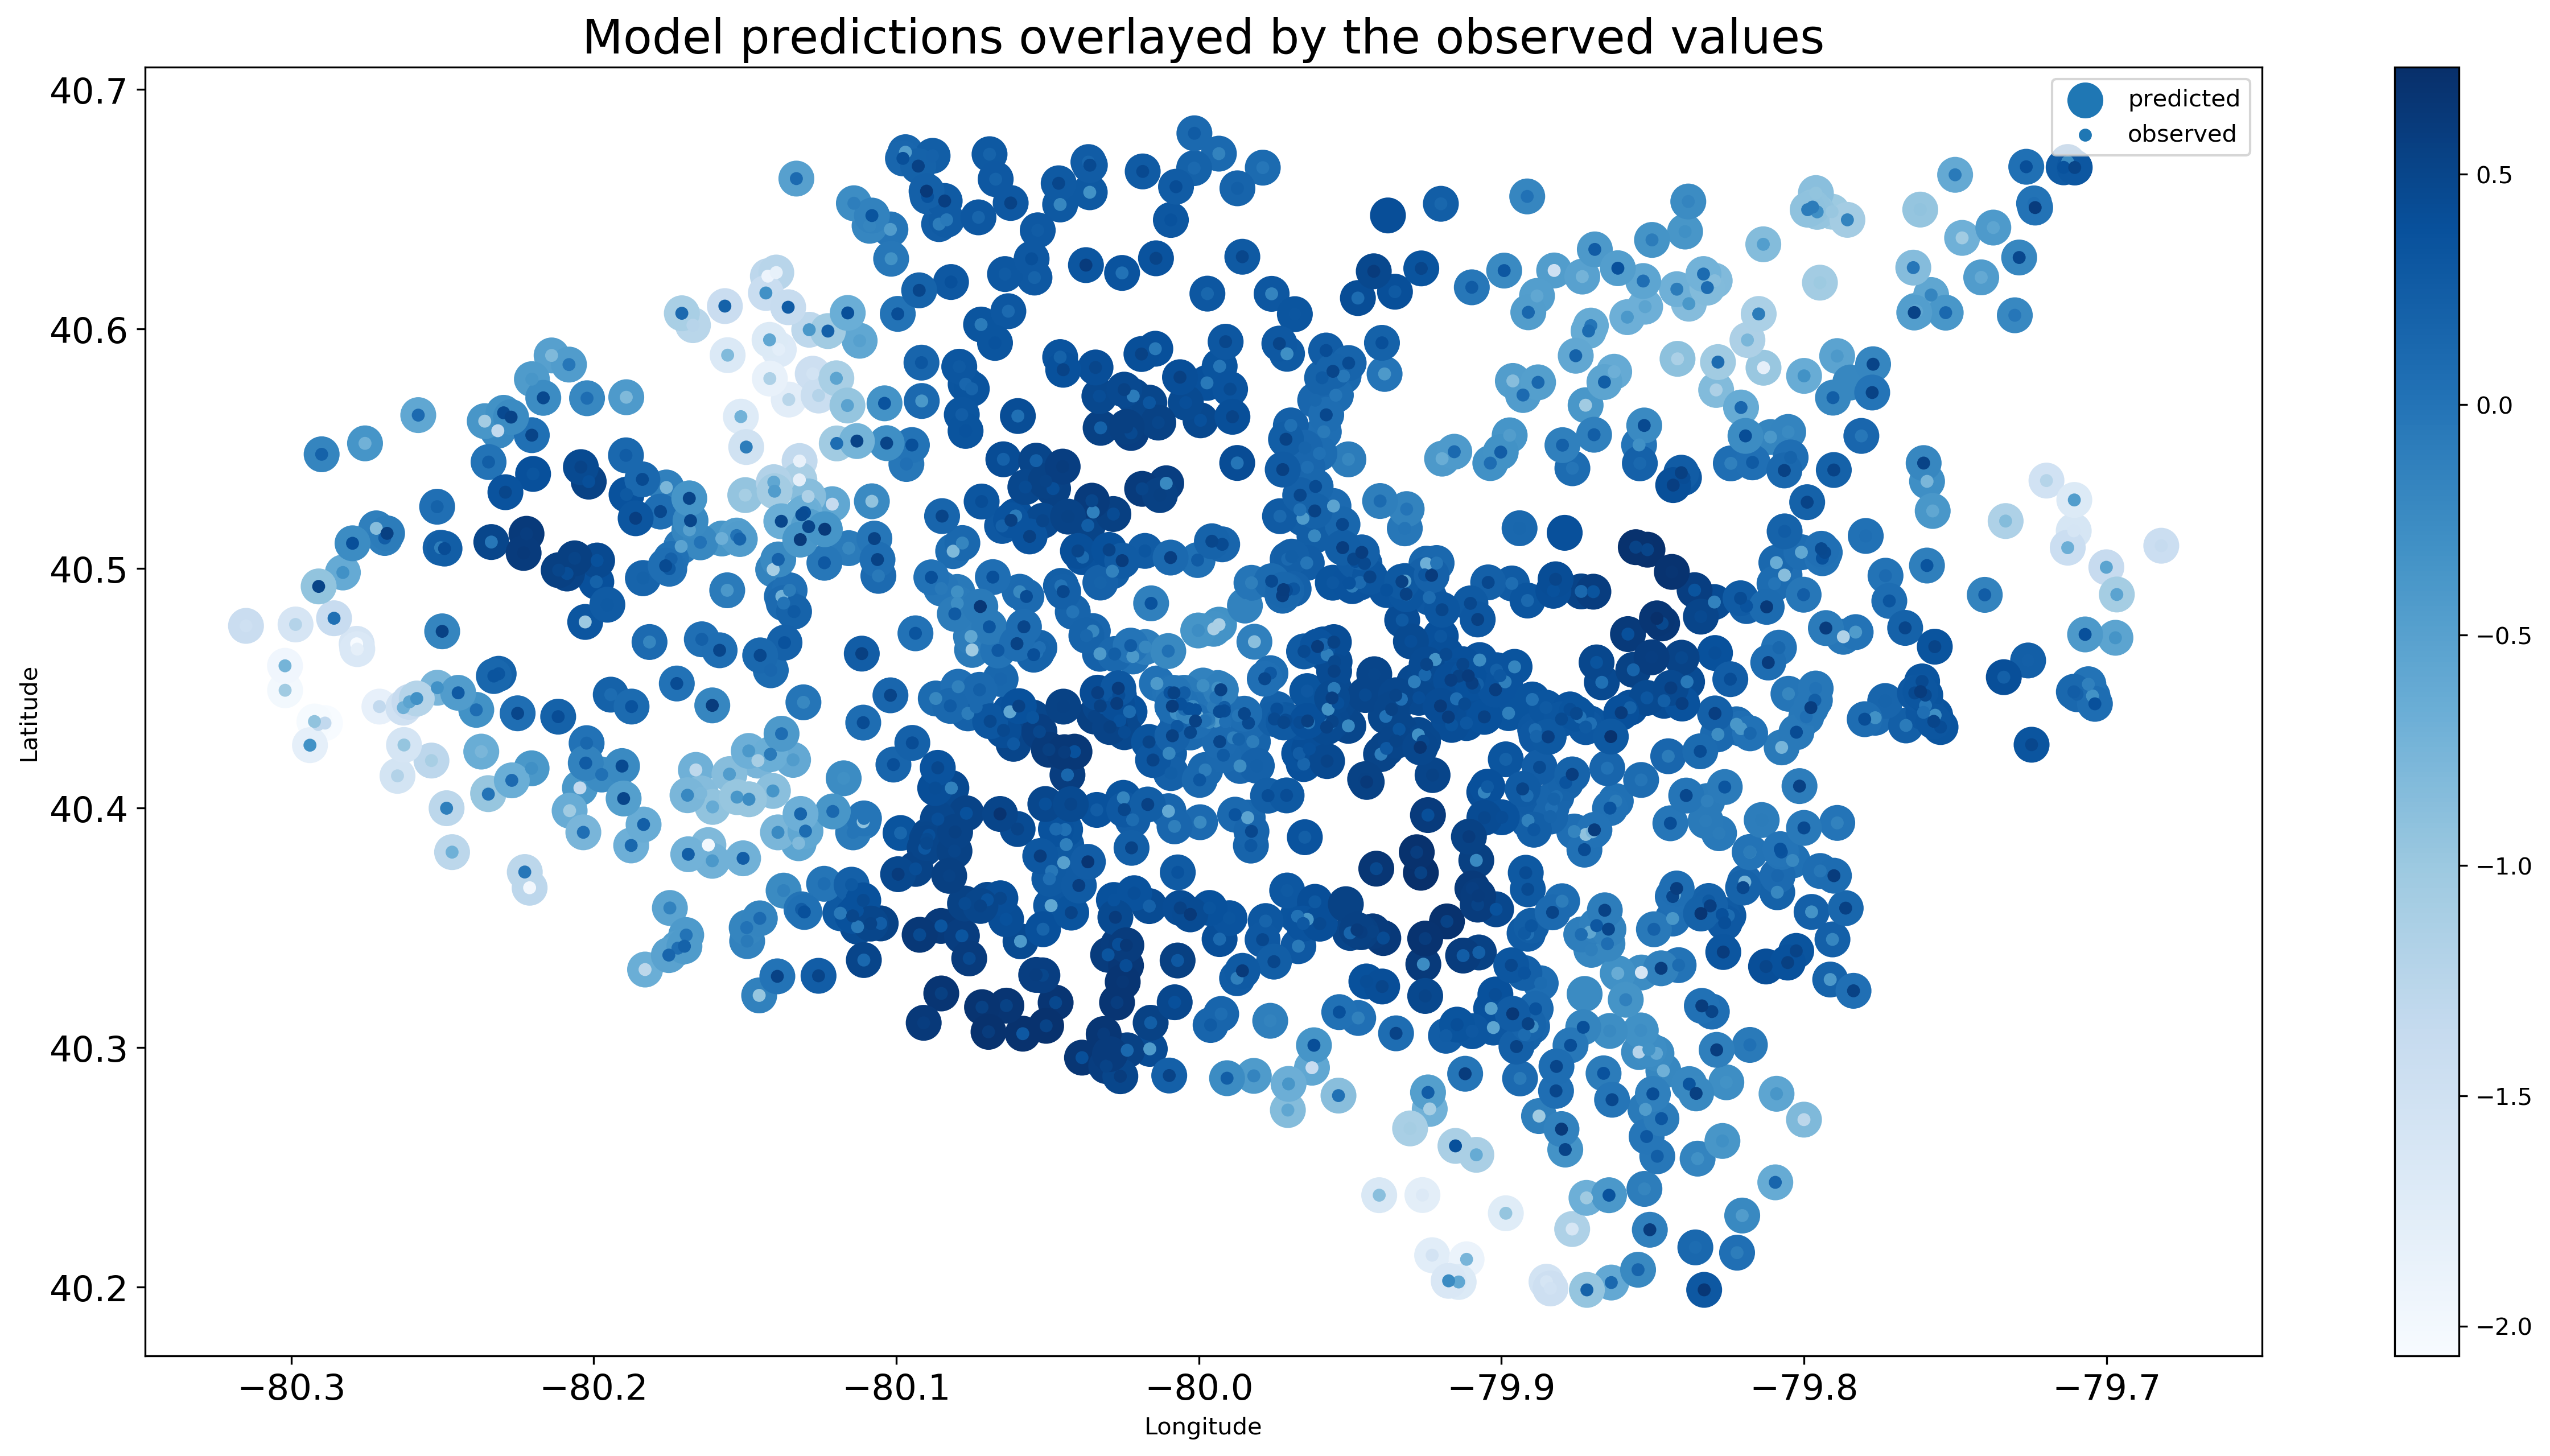

In [9]:
fig, ax = plt.subplots(figsize=(20,10), dpi=300)
df.plot(ax=ax, kind='scatter', x='Longitude', y='Latitude', c=df['y_pred'] , cmap='Blues', label='predicted', s=200, fontsize=15)
df.plot(ax=ax, kind='scatter', x='Longitude', y='Latitude', c=df['centered_log_counts'], cmap='Blues', label='observed', colorbar=False)
plt.title('Model predictions overlayed by the observed values', size=20)

In [10]:
print '{:0.3}% of sensors have average traffic counts more than two standard deviations higher or lower than the model\
predicts:'.format((df.centered_log_counts[(df.centered_log_counts < -2*(df.y_pred.std())) | (df.centered_log_counts > 2*(df.y_pred.std()))].count() 
                                                                                        / (1.*len(df)))*100)

13.5% of sensors have average traffic counts more than two standard deviations higher or lower than the modelpredicts:


Text(0.5,1,'Sensore location with observed values less more and within two standard deviations of predicted values')

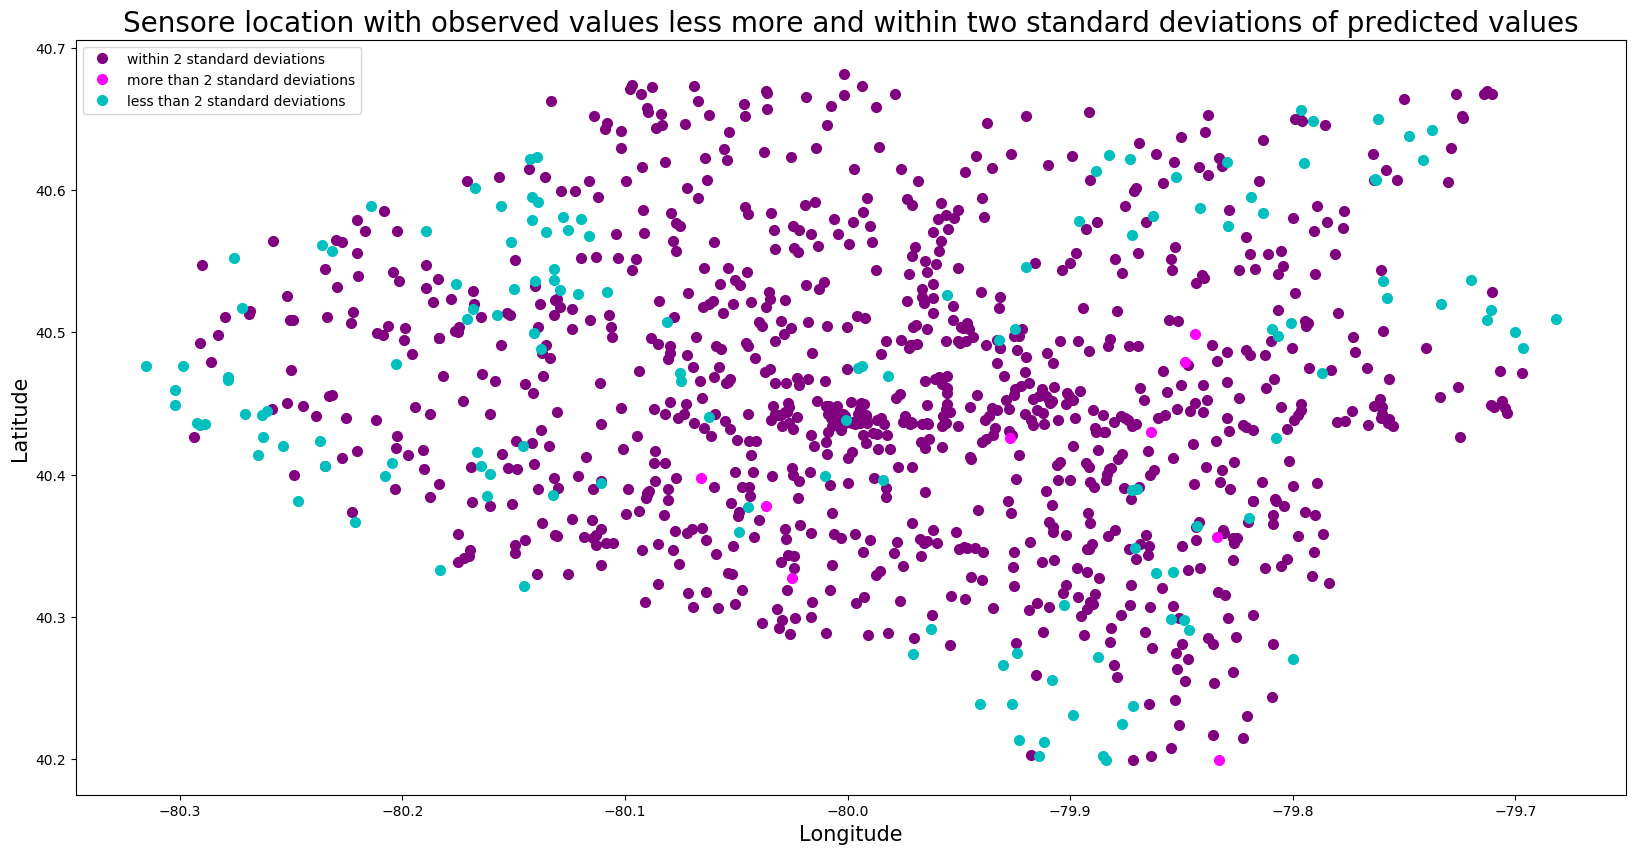

In [11]:
more = df.centered_log_counts > 2*(df.y_pred.std())
less = df.centered_log_counts < -2*(df.y_pred.std())

fig, ax = plt.subplots(figsize=(20,10), dpi=100)
plt.plot(df.Longitude[~more & ~less], df.Latitude[~more & ~less], color='purple', marker='o', linestyle='none', markersize=7, label='within 2 standard deviations')
plt.plot(df.Longitude[more], df.Latitude[more], color='magenta', marker='o', linestyle='none', markersize=7, label='more than 2 standard deviations')
plt.plot(df.Longitude[less], df.Latitude[less], color='c', marker='o', linestyle='none', markersize=7, label='less than 2 standard deviations')
plt.legend()
plt.xlabel('Longitude', size=15)
plt.ylabel('Latitude', size=15)
plt.title('Sensore location with observed values less more and within two standard deviations of predicted values', size=20)

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


#### Your solution here

point (1,0) is anomalous. The point is more than two standard deviation from the closest cluster center A.

point (35,2) is not anomalous. The point is within one standard deviation of the closest cluster center B .

point (15, 19) is anamalous. The point is within one standard deviation of the closest cluster center C. Yet this cluster only has two points. This is a low number with respect to the number of points in the other three clusters. Therefore, the points that fall in this cluster are considered anomalous.

point (10,11) is not anomalous. The point is within one standard deviation of the closest cluster center D.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

In [12]:
df = pd.read_csv("2016CountyHealthIndicators.csv")
df.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 31 columns):
County                                   3141 non-null object
'\% Reporting Fair/Poor Health'          3141 non-null object
'Physically Unhealthy Days Per Month'    3141 non-null object
'Mentally Unhealthy Days Per Month'      3141 non-null object
'\% Low birth weight births'             3141 non-null object
'\% Smokers'                             3141 non-null object
'\% Obese'                               3141 non-null int64
'Food Environment Index'                 3141 non-null float64
'\% Physically Inactive'                 3141 non-null int64
'\% With Access To Exercise'             3141 non-null object
'\% Excessive Drinking'                  3141 non-null object
'\% Alcohol-Impaired Driving Deaths'     3141 non-null object
'Chlamydia Rate'                         3141 non-null object
'Teen Birth Rate'                        3141 non-null object
'\% Uninsured'            

In [14]:
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], downcast='float', errors='coerce')
print df.shape , '\n'
print df.info()

(3141, 31) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Data columns (total 31 columns):
County                                   3141 non-null object
'\% Reporting Fair/Poor Health'          3140 non-null float32
'Physically Unhealthy Days Per Month'    3140 non-null float32
'Mentally Unhealthy Days Per Month'      3140 non-null float32
'\% Low birth weight births'             3042 non-null float32
'\% Smokers'                             3140 non-null float32
'\% Obese'                               3141 non-null float32
'Food Environment Index'                 3141 non-null float32
'\% Physically Inactive'                 3141 non-null float32
'\% With Access To Exercise'             3067 non-null float32
'\% Excessive Drinking'                  3140 non-null float32
'\% Alcohol-Impaired Driving Deaths'     3118 non-null float32
'Chlamydia Rate'                         2961 non-null float32
'Teen Birth Rate'                        3042 non-null float32

In [15]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)

df.tail(2)

(2486, 31)


,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
2484,"Washakie, Wyoming",14.0,3.3,3.3,6.0,16.0,25.0,8.2,22.0,61.0,...,16.0,4.5,29.0,22.500000,70.0,83.0,10.0,9.0,70.0,12.0
2485,"Weston, Wyoming",13.0,3.3,3.1,8.0,18.0,29.0,8.0,25.0,59.0,...,18.0,4.5,28.0,18.200001,98.0,112.0,10.7,8.0,68.0,22.0


### Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

In [16]:
# the six features ["'% Smokers'","'% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'% Children in Poverty'","'Average Daily PM2.5'"]
data = df.iloc[:, [5, 6, 21, 22, 25, 27]]
data.head()

,'\% Smokers','\% Obese','\% Children in Poverty','80/20 Income Ratio','Violent Crime Rate','Average Daily PM2.5'
0,19.0,31.0,18.0,4.3,254.0,12.9
1,19.0,27.0,20.0,4.5,221.0,13.1
2,21.0,41.0,38.0,5.3,147.0,12.6
3,21.0,40.0,27.0,4.3,236.0,12.9
4,19.0,32.0,24.0,4.1,219.0,12.7


In [17]:
# discretizing each feature into 5 categories 0,1,2,3,4
for col in data.columns:
    data[col] = pd.cut(data[col], 5, labels=['0', '1', '2', '3', '4'])

/ghome_gpfs/cusp/lj1232/.conda/envs/ml-bn/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
data.head()

,'\% Smokers','\% Obese','\% Children in Poverty','80/20 Income Ratio','Violent Crime Rate','Average Daily PM2.5'
0,1,2,1,1,0,3
1,1,2,1,1,0,3
2,2,4,3,2,0,3
3,2,4,2,1,0,3
4,1,2,2,1,0,3


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486 entries, 0 to 2485
Data columns (total 6 columns):
'\% Smokers'                2486 non-null category
'\% Obese'                  2486 non-null category
'\% Children in Poverty'    2486 non-null category
'80/20 Income Ratio'        2486 non-null category
'Violent Crime Rate'        2486 non-null category
'Average Daily PM2.5'       2486 non-null category
dtypes: category(6)
memory usage: 15.8 KB


In [20]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

/ghome_gpfs/cusp/lj1232/.conda/envs/ml-bn/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486 entries, 0 to 2485
Data columns (total 6 columns):
'\% Smokers'                2486 non-null int64
'\% Obese'                  2486 non-null int64
'\% Children in Poverty'    2486 non-null int64
'80/20 Income Ratio'        2486 non-null int64
'Violent Crime Rate'        2486 non-null int64
'Average Daily PM2.5'       2486 non-null int64
dtypes: int64(6)
memory usage: 116.6 KB


### (a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

In [22]:
# learn structure
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())

[("'\\% Smokers'", "'Average Daily PM2.5'"), ("'\\% Smokers'", "'\\% Obese'"), ("'\\% Children in Poverty'", "'Violent Crime Rate'"), ("'\\% Children in Poverty'", "'\\% Smokers'"), ("'80/20 Income Ratio'", "'\\% Children in Poverty'")]


In [23]:
# learn parameters
model = BayesianModel(best_model.edges())
model.fit(data, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print('CPD of {variable}:'.format(variable=cpd.variable))
    print(cpd)

CPD of '80/20 Income Ratio':
+-------------------------+------------+
| '80/20 Income Ratio'(0) | 0.131134   |
+-------------------------+------------+
| '80/20 Income Ratio'(1) | 0.704344   |
+-------------------------+------------+
| '80/20 Income Ratio'(2) | 0.140386   |
+-------------------------+------------+
| '80/20 Income Ratio'(3) | 0.0213194  |
+-------------------------+------------+
| '80/20 Income Ratio'(4) | 0.00281577 |
+-------------------------+------------+
CPD of 'Average Daily PM2.5':
+--------------------------+----------------------+----------------------+----------------------+-----------------+-----------------+
| '\% Smokers'             | '\% Smokers'(0)      | '\% Smokers'(1)      | '\% Smokers'(2)      | '\% Smokers'(3) | '\% Smokers'(4) |
+--------------------------+----------------------+----------------------+----------------------+-----------------+-----------------+
| 'Average Daily PM2.5'(0) | 0.2076923076923077   | 0.053204353083434096 | 0.00888888888

### (b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [24]:
# Compute log-likelihood of each data record given the model, 
# and report the lowest likelihood (most anomalous) records
# Log-likelihood of data record x given model

def LL(x, model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print thevariable,theparents,theprob
        loglike += np.log(theprob)
    return loglike

In [25]:
# compute anomalousness of each data records
exmp = data.apply(lambda x: LL(x, model), axis=1)

In [26]:
# 5 most anomalous data records
print exmp.sort_values().head(5)

1444   -16.608495
182    -14.827149
1577   -14.686742
1007   -14.457849
248    -13.671439
dtype: float64


In [27]:
data.iloc[list(exmp.sort_values().head(5).index)]

,'\% Smokers','\% Obese','\% Children in Poverty','80/20 Income Ratio','Violent Crime Rate','Average Daily PM2.5'
1444,0,0,2,4,1,2
182,0,0,1,3,1,0
1577,4,4,3,4,0,1
1007,1,1,2,4,2,2
248,1,1,2,3,3,3


In [28]:
df.iloc[list(exmp.sort_values().head(5).index), 0]

1444                            New York, New York
182                      San Francisco, California
1577                        Roulette, North Dakota
1007                        Suffolk, Massachusetts
248     District of Columbia, District of Columbia
Name: County, dtype: object

### Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

In [29]:
data2 = df.iloc[:,1:]
print data2.shape, '\n'
data2.head(2)

(2486, 30) 



,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,15.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
1,16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,15.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0


### (a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

In [30]:
# instatiating and fitting a k-means model with 3 clusters
KM = KMeans(n_clusters=3, random_state=999)
score = KM.fit_predict(data2)

# distance to each cluster center
res = pd.DataFrame(KM.transform(data2))
res.head()

,0,1,2
0,215.546368,554.609617,101.895485
1,108.370262,655.932344,186.335226
2,410.503731,530.643663,282.291939
3,168.209200,602.378878,141.457457
4,105.075152,777.335076,315.009861


In [31]:
# assigning a cluster to each data record
dis = pd.concat((res, pd.Series(score)), axis=1)
dis.columns = list(range(3)) + ['cluster']

# getting the distance of each record to its assigned cluster center (i.e. the shortest distance)
dis['distocenter'] = dis.apply(lambda x: x[int(x['cluster'])], axis=1)

dis.head()

,0,1,2,cluster,distocenter
0,215.546368,554.609617,101.895485,2,101.895485
1,108.370262,655.932344,186.335226,0,108.370262
2,410.503731,530.643663,282.291939,2,282.291939
3,168.209200,602.378878,141.457457,2,141.457457
4,105.075152,777.335076,315.009861,0,105.075152


In [32]:
# the 5 counties which have the longest distance
far = dis.sort_values('distocenter', ascending=False)[:5]
far

,0,1,2,cluster,distocenter
1890,2443.716031,1970.018443,2251.260167,1,1970.018443
1294,2036.147297,1332.735955,1759.249198,1,1332.735955
96,1917.732820,1208.900834,1639.063836,1,1208.900834
2304,1644.876605,1017.910163,1394.632068,1,1017.910163
995,1651.954082,918.374430,1366.737248,1,918.374430


In [33]:
df.iloc[far.index]

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
1890,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45.0,1.6,24.0,2.0,...,54.0,6.5,68.0,2.8,0.0,200.0,11.8,44.0,64.0,22.0
1294,"St. Louis City, Missouri",23.0,5.0,4.4,12.0,26.0,32.0,5.0,25.0,99.0,...,43.0,6.2,61.0,14.1,1885.0,98.0,11.9,23.0,71.0,25.0
96,"Crittenden, Arkansas",26.0,5.2,4.6,13.0,26.0,38.0,4.8,34.0,63.0,...,41.0,5.1,58.0,8.2,1764.0,65.0,12.7,20.0,83.0,31.0
2304,"Petersburg City, Virginia",26.0,4.5,4.0,13.0,23.0,38.0,4.4,28.0,93.0,...,38.0,4.9,68.0,16.6,560.0,81.0,12.3,18.0,79.0,23.0
995,"Baltimore City, Maryland",20.0,3.8,3.9,12.0,21.0,34.0,6.0,29.0,99.0,...,32.0,6.2,66.0,9.7,1449.0,99.0,12.6,24.0,60.0,39.0


In [34]:
counties = df.iloc[far.index, 0]
print 'The five counties with the largest distance (most anomalous) are: \n\n' , counties

The five counties with the largest distance (most anomalous) are: 

1890        Shannon, South Dakota
1294     St. Louis City, Missouri
96           Crittenden, Arkansas
2304    Petersburg City, Virginia
995      Baltimore City, Maryland
Name: County, dtype: object


### (b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

In [35]:
GM = GaussianMixture(n_components=3, random_state=999)
GM.fit(data2)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [36]:
# score_samples function gives the log of the probability density of each data record given its cluster.
# Note that probability densities can exceed 1 (unlike probabilities of discrete data).

# 5 most anomalous data points
temp = pd.DataFrame(GM.score_samples(data2)).sort_values(0)[:5]
temp

,0
1890,-197.420110
66,-133.042816
1444,-131.452095
2158,-129.450573
1577,-126.696035


In [37]:
counties = df.iloc[temp.index, 0]
print 'The five most anomalous counties are: \n\n' , counties

The five most anomalous counties are: 

1890     Shannon, South Dakota
66             Apache, Arizona
1444        New York, New York
2158            Willacy, Texas
1577    Roulette, North Dakota
Name: County, dtype: object


### Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

In [38]:
# Density based outlier detection mdoel
# instantiate the model
clf = LocalOutlierFactor(n_neighbors=20)

# fit_predict fits the model to the training set X and returns the labels.
# Label is 1 for an inlier and -1 for an outlier
y_pred = clf.fit_predict(data2)

# the lower the negative outlier factor is the more anomalous the data record is
temp = pd.DataFrame(y_pred, clf.negative_outlier_factor_).reset_index()
temp.columns = ['neg_outlier_factor', 'label']
temp.head()

/home/cusp/lj1232/.conda/envs/ml-bn/lib/python2.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


,neg_outlier_factor,label
0,-0.990791,1
1,-0.984715,1
2,-1.074760,1
3,-1.044016,1
4,-1.035767,1


In [39]:
# the 5 most anomalous recods 
anm = temp.sort_values('neg_outlier_factor')[:5]
anm

,neg_outlier_factor,label
1890,-4.855389,-1
1294,-2.600860,-1
96,-2.378684,-1
2378,-2.170029,-1
2304,-2.145245,-1


In [40]:
df.iloc[anm.index]

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
1890,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45.0,1.6,24.0,2.0,...,54.0,6.5,68.0,2.8,0.0,200.0,11.8,44.0,64.0,22.0
1294,"St. Louis City, Missouri",23.0,5.0,4.4,12.0,26.0,32.0,5.0,25.0,99.0,...,43.0,6.2,61.0,14.1,1885.0,98.0,11.9,23.0,71.0,25.0
96,"Crittenden, Arkansas",26.0,5.2,4.6,13.0,26.0,38.0,4.8,34.0,63.0,...,41.0,5.1,58.0,8.2,1764.0,65.0,12.7,20.0,83.0,31.0
2378,"Nicholas, West Virginia",22.0,4.8,4.7,10.0,25.0,36.0,7.6,39.0,45.0,...,27.0,4.9,23.0,13.5,813.0,118.0,13.2,9.0,88.0,38.0
2304,"Petersburg City, Virginia",26.0,4.5,4.0,13.0,23.0,38.0,4.4,28.0,93.0,...,38.0,4.9,68.0,16.6,560.0,81.0,12.3,18.0,79.0,23.0


In [41]:
counties = df.iloc[anm.index, 0]
print 'The five most anomalous counties are: \n\n' , counties

The five most anomalous counties are: 

1890        Shannon, South Dakota
1294     St. Louis City, Missouri
96           Crittenden, Arkansas
2378      Nicholas, West Virginia
2304    Petersburg City, Virginia
Name: County, dtype: object


### Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

When comparing the performance of models that saw all the data (part 2) we notice that clustering with K-means and using a density based model i.e. Local Outlier Factor labeled the same counties as outliers. Shannon, South Dakota have appeared in almost all of the models as an outlier. It shows multiple outlier values for example a violent crime rate of zero, a very low (2%) access to exercise, low graduation rate (3), and high unemployment (13%). St. Louis City, Missouri, Crittenden, Arkansas, Petersburg City, Virginia, and Baltimore City, Maryland all show high chlamydia rate and high violent crime rate. St. Louis City, Missouri also shows a very high percentage of people having access to exercise (99%). Model based anomaly detection using bayesian modeling labled San Francisco, California, Suffolk, Massachusetts, and District of Columbia, District of Columbia as anomalies while no other model did. These counties alog with New York show low smoking and obesity percentages accompanied with high income ratios. Roulette, North Dakota on the other hand detected as an anomaly by the same model shows high smoking, obesity and income ration and low violent crime ratio. Anomaly detection using gaussian mixture mdoels is the only method that labeled Apache, Arizona and Willacy, Texas as outlies. Apaches shows a low food index(0.5) and Willacy show that 0% of people have access to exercise.